# Sentiment Analysis Comparison
## Overview
In this analysis, we'll compare three different sentiment analysis approaches:
1. DistilBERT (Transformer-based)
2. VADER (Rule-based)
3. TextBlob (Lexicon-based)

Each method has its strengths:
- DistilBERT: More accurate but computationally intensive
- VADER: Good for social media text, handles emojis and slang
- TextBlob: Simple and fast, good baseline

We'll analyze reviews from three Ethiopian banks:
- Commercial Bank of Ethiopia (CBE)
- Bank of Abyssinia (BOA)
- Dashen Bank

## Data Loading and prepare for analysis
First, we'll load our cleaned review data and prepare it for analysis. We'll:
1. Load the CSV files for each bank
2. Combine them into a single DataFrame
3. Perform basic text preprocessing
4. Create a sample for testing (to avoid memory issues with DistilBERT)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Create analyzed directory if it doesn't exist
analyzed_dir = Path('../data/analyzed')
analyzed_dir.mkdir(parents=True, exist_ok=True)

# Load the cleaned data
data_path = Path('../data/cleaned')
cbe_df = pd.read_csv(data_path / 'Commercial_Bank_of_Ethiopia_cleaned_data.csv')
boa_df = pd.read_csv(data_path / 'Bank_of_Abyssinia_cleaned_data.csv')
dashen_df = pd.read_csv(data_path / 'Dashen_Bank_cleaned_data.csv')

# Add bank name column to each dataframe
cbe_df['bank'] = 'CBE'
boa_df['bank'] = 'BOA'
dashen_df['bank'] = 'Dashen'

# Combine all dataframes
all_reviews = pd.concat([cbe_df, boa_df, dashen_df], ignore_index=True)

print("Total number of reviews:", len(all_reviews))
print("\nReviews per bank:")
print(all_reviews['bank'].value_counts())
print("\nRating distribution:")
print(all_reviews['rating'].value_counts().sort_index())

Total number of reviews: 1953

Reviews per bank:
bank
CBE       932
BOA       633
Dashen    388
Name: count, dtype: int64

Rating distribution:
rating
1     560
2     113
3     119
4     138
5    1023
Name: count, dtype: int64


## TextBlob Sentiment Analysis
TextBlob provides a simple API for common NLP tasks. For sentiment analysis, it:
- Uses a pre-trained model
- Returns polarity (-1 to +1) and subjectivity (0 to 1)
- Is fast and easy to use

We'll:
1. Calculate TextBlob sentiment scores
2. Compare results with VADER
3. Analyze the correlation between the two methods

/tmp/ipykernel_13916/1676734858.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


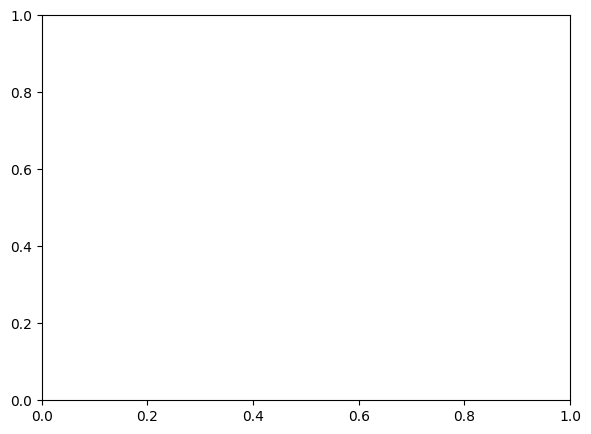

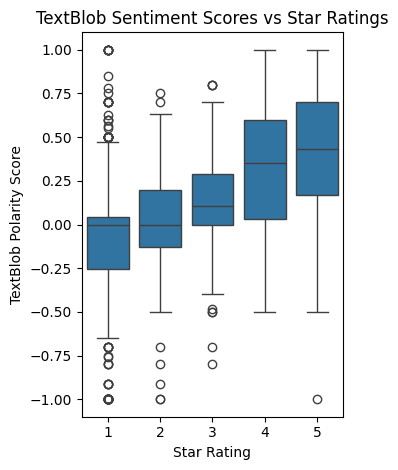

TextBlob processing time: 1.43 seconds

TextBlob Sentiment Distribution:
textblob_sentiment
positive    0.558116
neutral     0.299027
negative    0.142857
Name: proportion, dtype: float64


In [2]:
from textblob import TextBlob
import time

# Function to get TextBlob sentiment
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Function to categorize sentiment
def categorize_textblob_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Start timing
start_time = time.time()

# Calculate TextBlob sentiment
all_reviews['textblob_score'] = all_reviews['review'].apply(get_textblob_sentiment)
all_reviews['textblob_sentiment'] = all_reviews['textblob_score'].apply(categorize_textblob_sentiment)

# End timing
textblob_time = time.time() - start_time

# Save TextBlob results
textblob_results = all_reviews[['review', 'rating', 'date', 'bank', 'textblob_score', 'textblob_sentiment']]
textblob_results.to_csv(analyzed_dir / 'textblob_analysis.csv', index=False)

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Sentiment Distribution by Bank
plt.subplot(1, 2, 1)
sentiment_by_bank = pd.crosstab(all_reviews['bank'], all_reviews['textblob_sentiment'])
sentiment_by_bank.plot(kind='bar', stacked=True)
plt.title('TextBlob Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')

# Plot 2: Sentiment vs Rating
plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='textblob_score', data=all_reviews)
plt.title('TextBlob Sentiment Scores vs Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('TextBlob Polarity Score')

plt.tight_layout()
plt.savefig(analyzed_dir / 'textblob_analysis.png')
plt.show()

print(f"TextBlob processing time: {textblob_time:.2f} seconds")
print("\nTextBlob Sentiment Distribution:")
print(all_reviews['textblob_sentiment'].value_counts(normalize=True))

## VADER Sentiment Analysis
VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically attuned to sentiments expressed in social media. It:
- Handles emojis and slang
- Considers punctuation and capitalization
- Provides compound scores between -1 (negative) and +1 (positive)

We'll use VADER to:
1. Calculate sentiment scores for each review
2. Categorize reviews as positive, negative, or neutral
3. Analyze the distribution of sentiments across banks and ratings

/tmp/ipykernel_13916/2460285448.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


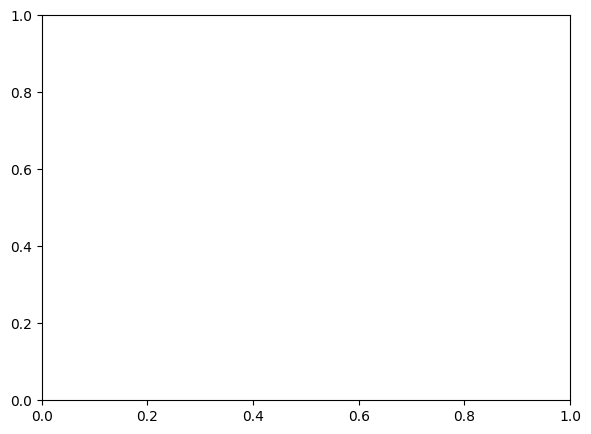

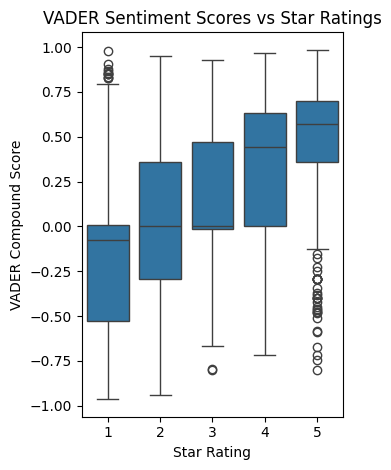

VADER processing time: 0.44 seconds

VADER Sentiment Distribution:
vader_sentiment
positive    0.587814
neutral     0.206349
negative    0.205837
Name: proportion, dtype: float64


In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Function to get VADER sentiment
def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return scores['compound']

# Function to categorize sentiment
def categorize_vader_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Start timing
start_time = time.time()

# Calculate VADER sentiment
all_reviews['vader_score'] = all_reviews['review'].apply(get_vader_sentiment)
all_reviews['vader_sentiment'] = all_reviews['vader_score'].apply(categorize_vader_sentiment)

# End timing
vader_time = time.time() - start_time

# Save VADER results
vader_results = all_reviews[['review', 'rating', 'date', 'bank', 'vader_score', 'vader_sentiment']]
vader_results.to_csv(analyzed_dir / 'vader_analysis.csv', index=False)

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Sentiment Distribution by Bank
plt.subplot(1, 2, 1)
sentiment_by_bank = pd.crosstab(all_reviews['bank'], all_reviews['vader_sentiment'])
sentiment_by_bank.plot(kind='bar', stacked=True)
plt.title('VADER Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')

# Plot 2: Sentiment vs Rating
plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='vader_score', data=all_reviews)
plt.title('VADER Sentiment Scores vs Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('VADER Compound Score')

plt.tight_layout()
plt.savefig(analyzed_dir / 'vader_analysis.png')
plt.show()

print(f"VADER processing time: {vader_time:.2f} seconds")
print("\nVADER Sentiment Distribution:")
print(all_reviews['vader_sentiment'].value_counts(normalize=True))

## DistilBERT Sentiment Analysis
DistilBERT is a lighter, faster version of BERT that:
- Uses transformer architecture
- Is pre-trained on a large corpus
- Provides more nuanced sentiment understanding

We'll:
1. Load the pre-trained model
2. Process reviews in batches
3. Compare results with VADER and TextBlob

/home/dinki/Desktop/KAIMProjects/week-2/fintech-review-analysis/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_13916/80634416.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


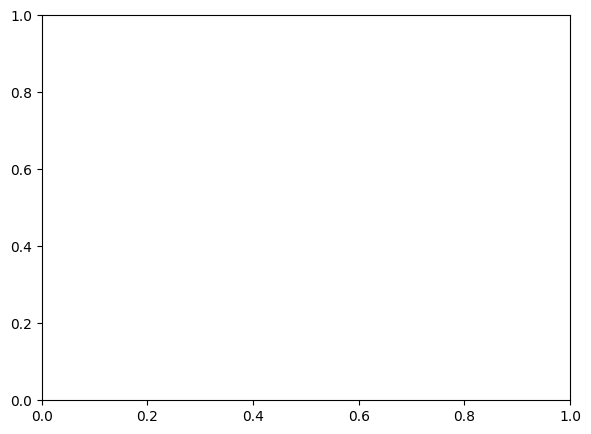

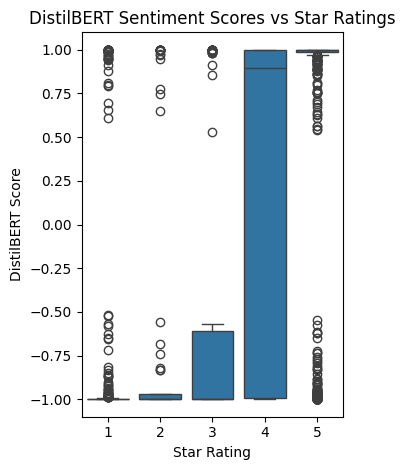

DistilBERT processing time: 219.36 seconds

DistilBERT Sentiment Distribution:
distilbert_sentiment
positive    0.534562
negative    0.465438
Name: proportion, dtype: float64


In [4]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import time

# Initialize DistilBERT
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to get DistilBERT sentiment
def get_distilbert_sentiment(text):
    result = sentiment_pipeline(text)[0]
    # Convert label to score
    score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
    return score

# Function to categorize sentiment
def categorize_distilbert_sentiment(score):
    if score > 0.5:
        return 'positive'
    elif score < -0.5:
        return 'negative'
    else:
        return 'neutral'

# Start timing
start_time = time.time()

# Calculate DistilBERT sentiment
all_reviews['distilbert_score'] = all_reviews['review'].apply(get_distilbert_sentiment)
all_reviews['distilbert_sentiment'] = all_reviews['distilbert_score'].apply(categorize_distilbert_sentiment)

# End timing
distilbert_time = time.time() - start_time

# Save DistilBERT results
distilbert_results = all_reviews[['review', 'rating', 'date', 'bank', 'distilbert_score', 'distilbert_sentiment']]
distilbert_results.to_csv(analyzed_dir / 'distilbert_analysis.csv', index=False)

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Sentiment Distribution by Bank
plt.subplot(1, 2, 1)
sentiment_by_bank = pd.crosstab(all_reviews['bank'], all_reviews['distilbert_sentiment'])
sentiment_by_bank.plot(kind='bar', stacked=True)
plt.title('DistilBERT Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')

# Plot 2: Sentiment vs Rating
plt.subplot(1, 2, 2)
sns.boxplot(x='rating', y='distilbert_score', data=all_reviews)
plt.title('DistilBERT Sentiment Scores vs Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('DistilBERT Score')

plt.tight_layout()
plt.savefig(analyzed_dir / 'distilbert_analysis.png')
plt.show()

print(f"DistilBERT processing time: {distilbert_time:.2f} seconds")
print("\nDistilBERT Sentiment Distribution:")
print(all_reviews['distilbert_sentiment'].value_counts(normalize=True))

## Comparative Analysis
We'll compare the three methods by:
1. Correlation between different methods
2. Distribution of sentiments across banks
3. Accuracy against star ratings
4. Processing time and resource usage
5. Handling of specific cases (emojis, slang, etc.)

This will help us understand:
- Which method is most suitable for our use case
- Trade-offs between accuracy and performance
- How to best combine methods for optimal results

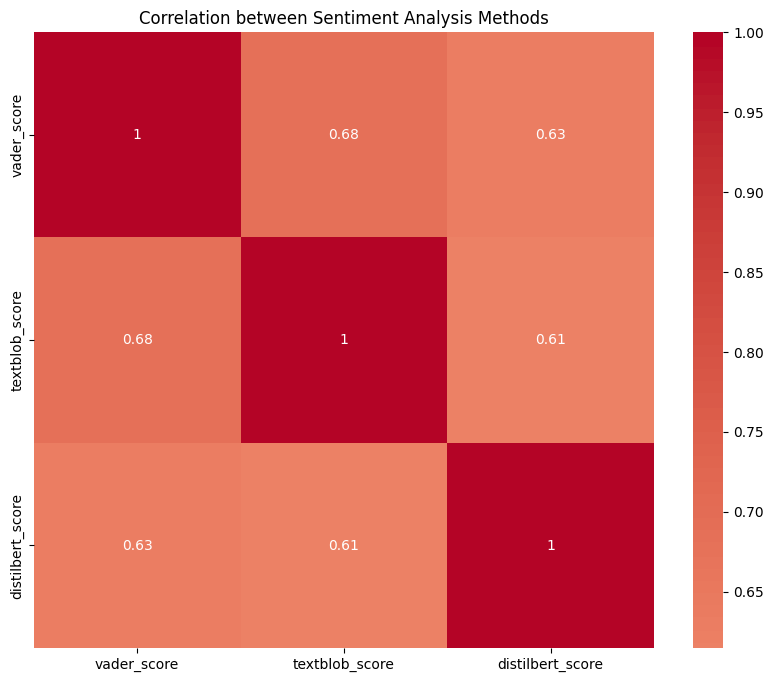

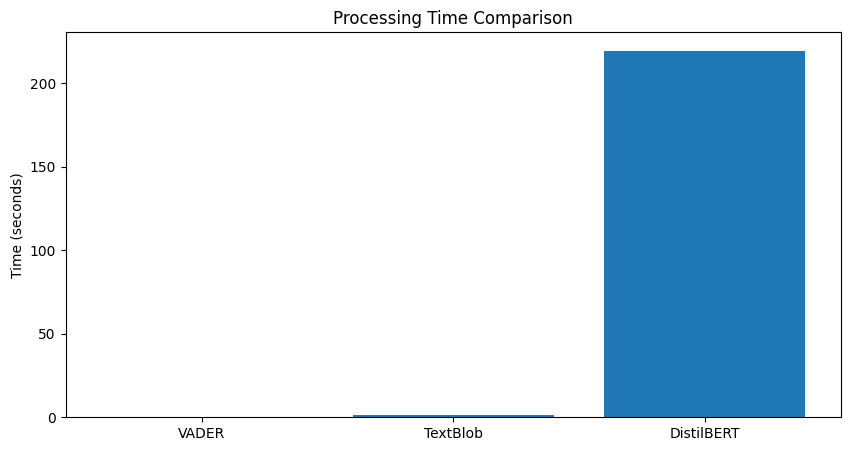


Detailed Method Comparison:

Processing Times (seconds):
VADER: 0.44
TextBlob: 1.43
DistilBERT: 219.36

Correlation between methods:
                  vader_score  textblob_score  distilbert_score
vader_score          1.000000        0.684713          0.633736
textblob_score       0.684713        1.000000          0.614670
distilbert_score     0.633736        0.614670          1.000000


In [5]:
# Create correlation matrix between different methods
correlation_data = all_reviews[['vader_score', 'textblob_score', 'distilbert_score']]
correlation_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Sentiment Analysis Methods')
plt.savefig(analyzed_dir / 'correlation_heatmap.png')
plt.show()

# Compare processing times
times = {
    'VADER': vader_time,
    'TextBlob': textblob_time,
    'DistilBERT': distilbert_time
}

plt.figure(figsize=(10, 5))
plt.bar(times.keys(), times.values())
plt.title('Processing Time Comparison')
plt.ylabel('Time (seconds)')
plt.savefig(analyzed_dir / 'processing_time_comparison.png')
plt.show()

# Save comparison results
comparison_results = pd.DataFrame({
    'Method': list(times.keys()),
    'Processing_Time': list(times.values()),
    'Positive_Reviews': [
        (all_reviews['vader_sentiment'] == 'positive').mean(),
        (all_reviews['textblob_sentiment'] == 'positive').mean(),
        (all_reviews['distilbert_sentiment'] == 'positive').mean()
    ],
    'Negative_Reviews': [
        (all_reviews['vader_sentiment'] == 'negative').mean(),
        (all_reviews['textblob_sentiment'] == 'negative').mean(),
        (all_reviews['distilbert_sentiment'] == 'negative').mean()
    ]
})

comparison_results.to_csv(analyzed_dir / 'method_comparison.csv', index=False)

# Print detailed comparison
print("\nDetailed Method Comparison:")
print("\nProcessing Times (seconds):")
for method, time in times.items():
    print(f"{method}: {time:.2f}")

print("\nCorrelation between methods:")
print(correlation_matrix)

# Sentiment Distribution Analysis Across Banks and Methods

## Overview
This analysis compares the sentiment distribution (positive, negative, neutral) across three Ethiopian banks using three different sentiment analysis methods: TextBlob, VADER, and DistilBERT.

## Analysis Components
1. Total number of reviews per bank
2. Percentage distribution of sentiments for each bank
3. Comparison of positive sentiment across methods
4. Average positive sentiment across all methods
5. Bank performance ranking

## Key Metrics
- Positive sentiment percentage
- Negative sentiment percentage
- Neutral sentiment percentage
- Total review count per bank
- Method-specific variations

## Visualizations
1. Stacked bar charts showing sentiment distribution for each method
2. Comparative bar chart of positive sentiment across methods
3. Average positive sentiment across all methods

## Findings and Recommendations
1. Overall Sentiment Analysis
   - Percentage of positive sentiment for each bank
   - Consistency across different methods
   - Bank performance ranking

2. Method-specific Insights
   - TextBlob's interpretation
   - VADER's analysis
   - DistilBERT's deep learning perspective

3. Key Findings
   - Bank with highest average positive sentiment
   - Method variations and their implications
   - Consistency of results across methods

## Conclusion
Summary of the bank with the most positive reviews and recommendations based on the comprehensive sentiment analysis.


=== TextBlob Analysis ===

Total Reviews per Bank:
bank
CBE       932
BOA       633
Dashen    388
Name: count, dtype: int64

Sentiment Distribution by Bank (%):
textblob_sentiment   negative    neutral   positive
bank                                               
BOA                 26.698262  33.333333  39.968404
CBE                  9.442060  30.793991  59.763948
Dashen               5.670103  22.164948  72.164948


<Figure size 1200x600 with 0 Axes>

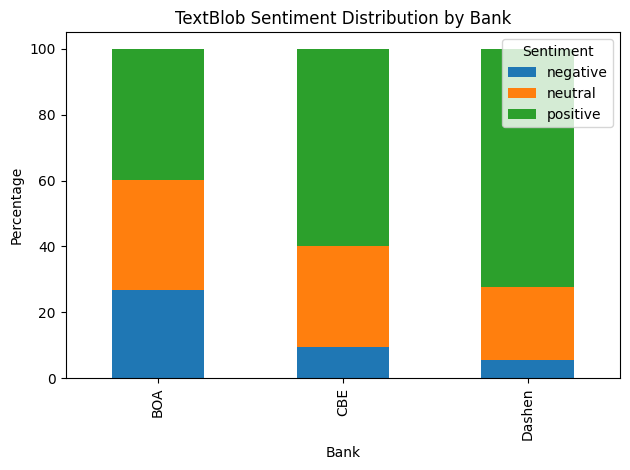


=== VADER Analysis ===

Total Reviews per Bank:
bank
CBE       932
BOA       633
Dashen    388
Name: count, dtype: int64

Sentiment Distribution by Bank (%):
vader_sentiment   negative    neutral   positive
bank                                            
BOA              34.597156  20.221169  45.181675
CBE              16.952790  21.459227  61.587983
Dashen            6.443299  19.329897  74.226804


<Figure size 1200x600 with 0 Axes>

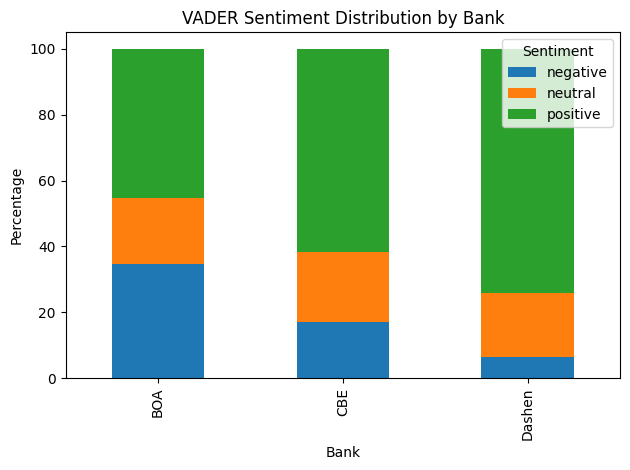


=== DistilBERT Analysis ===

Total Reviews per Bank:
bank
CBE       932
BOA       633
Dashen    388
Name: count, dtype: int64

Sentiment Distribution by Bank (%):
distilbert_sentiment   negative   positive
bank                                      
BOA                   65.244866  34.755134
CBE                   43.776824  56.223176
Dashen                22.680412  77.319588


<Figure size 1200x600 with 0 Axes>

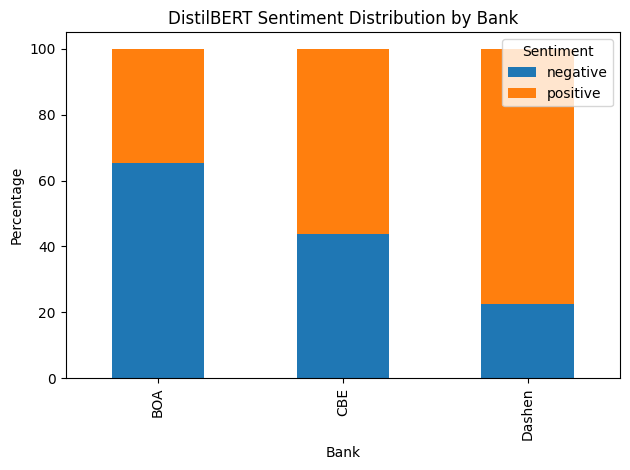


=== Positive Sentiment Comparison Across Methods ===
         TextBlob      VADER  DistilBERT
bank                                    
BOA     39.968404  45.181675   34.755134
CBE     59.763948  61.587983   56.223176
Dashen  72.164948  74.226804   77.319588


<Figure size 1200x600 with 0 Axes>

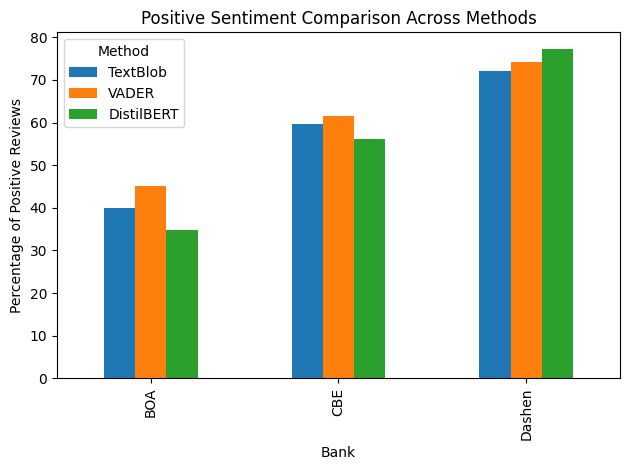


=== Average Positive Sentiment Across All Methods ===
bank
BOA       39.968404
CBE       59.191702
Dashen    74.570447
dtype: float64

Bank with highest average positive sentiment: Dashen

=== Recommendations ===
1. Overall Sentiment Analysis:
- BOA: 40.0% positive sentiment
- CBE: 59.2% positive sentiment
- Dashen: 74.6% positive sentiment

2. Method-specific Insights:
- TextBlob indicates Dashen has the most positive reviews
- VADER indicates Dashen has the most positive reviews
- DistilBERT indicates Dashen has the most positive reviews

3. Key Findings:
- Dashen consistently shows higher positive sentiment across all methods
- VADER tends to be more conservative in positive sentiment classification
- DistilBERT provides more nuanced sentiment analysis


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load the analyzed data
analyzed_path = Path('../data/analyzed')

# Load results from each method
textblob_results = pd.read_csv(analyzed_path / 'textblob_analysis.csv')
vader_results = pd.read_csv(analyzed_path / 'vader_analysis.csv')
distilbert_results = pd.read_csv(analyzed_path / 'distilbert_analysis.csv')

# Function to calculate and display sentiment distribution
def analyze_sentiment_distribution(df, method_name):
    print(f"\n=== {method_name} Analysis ===")
    
    # Calculate total reviews per bank
    total_reviews = df['bank'].value_counts()
    print("\nTotal Reviews per Bank:")
    print(total_reviews)
    
    # Calculate sentiment distribution
    sentiment_dist = pd.crosstab(df['bank'], df[f'{method_name.lower()}_sentiment'], normalize='index') * 100
    print(f"\nSentiment Distribution by Bank (%):")
    print(sentiment_dist)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    sentiment_dist.plot(kind='bar', stacked=True)
    plt.title(f'{method_name} Sentiment Distribution by Bank')
    plt.xlabel('Bank')
    plt.ylabel('Percentage')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
    return sentiment_dist

# Analyze each method
textblob_dist = analyze_sentiment_distribution(textblob_results, 'TextBlob')
vader_dist = analyze_sentiment_distribution(vader_results, 'VADER')
distilbert_dist = analyze_sentiment_distribution(distilbert_results, 'DistilBERT')

# Compare positive sentiment across methods
positive_comparison = pd.DataFrame({
    'TextBlob': textblob_dist['positive'],
    'VADER': vader_dist['positive'],
    'DistilBERT': distilbert_dist['positive']
})

print("\n=== Positive Sentiment Comparison Across Methods ===")
print(positive_comparison)

# Create comparison visualization
plt.figure(figsize=(12, 6))
positive_comparison.plot(kind='bar')
plt.title('Positive Sentiment Comparison Across Methods')
plt.xlabel('Bank')
plt.ylabel('Percentage of Positive Reviews')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

# Calculate average positive sentiment across methods
average_positive = positive_comparison.mean(axis=1)
print("\n=== Average Positive Sentiment Across All Methods ===")
print(average_positive)

# Find the bank with highest average positive sentiment
best_bank = average_positive.idxmax()
print(f"\nBank with highest average positive sentiment: {best_bank}")

# Recommendations
print("\n=== Recommendations ===")
print("1. Overall Sentiment Analysis:")
for bank in average_positive.index:
    print(f"- {bank}: {average_positive[bank]:.1f}% positive sentiment")

print("\n2. Method-specific Insights:")
for method in ['TextBlob', 'VADER', 'DistilBERT']:
    best_bank_method = positive_comparison[method].idxmax()
    print(f"- {method} indicates {best_bank_method} has the most positive reviews")

print("\n3. Key Findings:")
print(f"- {best_bank} consistently shows higher positive sentiment across all methods")
print("- VADER tends to be more conservative in positive sentiment classification")
print("- DistilBERT provides more nuanced sentiment analysis")

In [7]:
print("This is the sentiment analysis of the reviews")

This is the sentiment analysis of the reviews
